In [1]:
#-----------------------------------------------------------
# IMPORT ALL NECESSARY MODULES
#-----------------------------------------------------------

import numpy as np
%matplotlib inline 
import pandas as pd
import tensorflow as tf
from IPython.display import display, Image
import cv2
from PIL import Image
from tqdm import tqdm
from keras.applications.vgg19 import VGG19
from keras.utils.vis_utils import plot_model
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

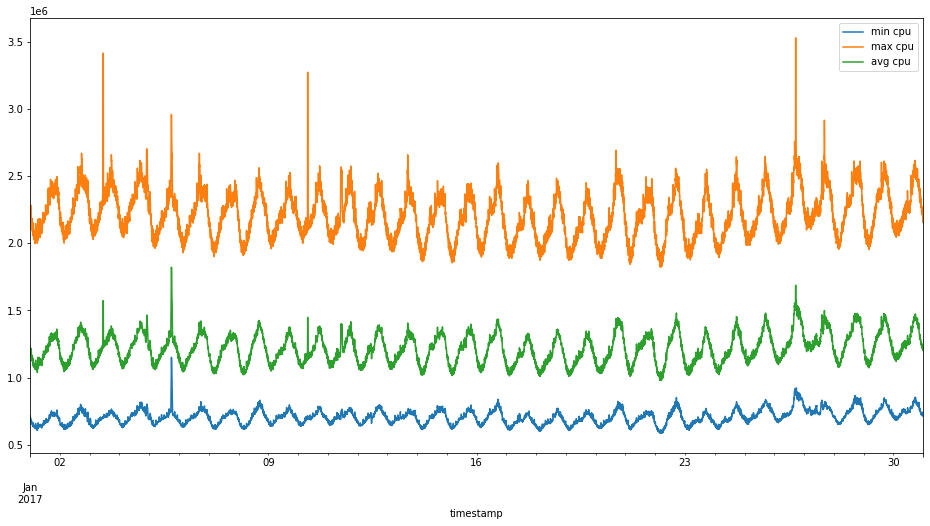

In [2]:
#-----------------------------------------------------------
# LOAD THE DATASET AND PLOT THE OBSERVATIONS
#-----------------------------------------------------------

df = pd.read_csv('../input/azure-data/AzureReadings_at_a_timestamp.csv')
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()
df.plot(figsize=(16, 8))
plt.show()

In [3]:
#-----------------------------------------------------------
# CREATE TRAIN-TEST SPLIT (80:20)
#-----------------------------------------------------------
TRAIN_LENGTH = round(len(df)*0.8)
TEST_LENGTH = len(df) - TRAIN_LENGTH
train = df.iloc[0:TRAIN_LENGTH]
test = df[TRAIN_LENGTH : ]

In [4]:
#-----------------------------------------------------------
# SCALING VALUES
#-----------------------------------------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=df.columns)
test_scaled = pd.DataFrame(scaler.transform(test), columns=df.columns)

In [5]:
#-----------------------------------------------------------
# GENERATOR TO DATA TO FEED INTO MODEL
#-----------------------------------------------------------
def train_generator(dataset, n_lags=1):
    dataX, dataY = [], []
    for i in range(len(dataset)- n_lags -1):
        a = dataset.iloc[i:(i+n_lags)].to_numpy()
        dataX.append(a)
        dataY.append(dataset.iloc[i + n_lags].to_numpy())
    return (np.array(dataX), np.array(dataY))

In [6]:
#-----------------------------------------------------------
# DEFINING INPUTS AND EXPECTED OBSERVATIONS
#-----------------------------------------------------------
TIME_STEPS = 500
X_train, y_train = train_generator(train_scaled, n_lags = TIME_STEPS)
X_test_scaled, y_test_scaled = train_generator(test_scaled, n_lags = TIME_STEPS)
X_test, y_test = train_generator(test, n_lags = TIME_STEPS)

In [7]:
#-----------------------------------------------------------
# USING A LSTM MODEL FOR PREDICTION ON TIME SERIES
#-----------------------------------------------------------
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(512,input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True))
model.add(tf.keras.layers.LSTM(512,return_sequences=False))
model.add(tf.keras.layers.Dense(3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500, 512)          1056768   
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 3,157,507
Trainable params: 3,157,507
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='mean_absolute_error', optimizer= tf.keras.optimizers.Adam())

In [9]:
#-----------------------------------------------------------
# DEFINING CALLBACKS
#-----------------------------------------------------------
es = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
lr_red = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1, min_lr=0.0000001,)

In [13]:
callbacks = [es , lr_red]
history = model.fit(X_train, y_train, 
                    epochs=200, 
                    validation_split=0.25,
                    batch_size=256,
                    verbose=1, 
                    shuffle=False, 
                    callbacks = callbacks)

#-----------------------------------------------------------
# I TRAINED MY MODEL ON BATCHSIZES - 64,128,256
#-----------------------------------------------------------

Epoch 1/200
19/19 [==============================] - 9s 494ms/step - loss: 0.0138 - val_loss: 0.0150 - lr: 1.0000e-07
Epoch 2/200
19/19 [==============================] - 9s 493ms/step - loss: 0.0138 - val_loss: 0.0150 - lr: 1.0000e-07
Epoch 3/200
19/19 [==============================] - 9s 497ms/step - loss: 0.0138 - val_loss: 0.0150 - lr: 1.0000e-07
Epoch 4/200
19/19 [==============================] - 9s 494ms/step - loss: 0.0138 - val_loss: 0.0150 - lr: 1.0000e-07
Epoch 5/200
19/19 [==============================] - ETA: 0s - loss: 0.0138
Epoch 00005: ReduceLROnPlateau reducing learning rate to 1e-07.
19/19 [==============================] - 9s 494ms/step - loss: 0.0138 - val_loss: 0.0150 - lr: 1.0000e-07
Epoch 6/200
19/19 [==============================] - 9s 493ms/step - loss: 0.0138 - val_loss: 0.0150 - lr: 1.0000e-07
Epoch 7/200
19/19 [==============================] - 9s 493ms/step - loss: 0.0138 - val_loss: 0.0150 - lr: 1.0000e-07
Epoch 8/200
19/19 [===========================

KeyboardInterrupt: 

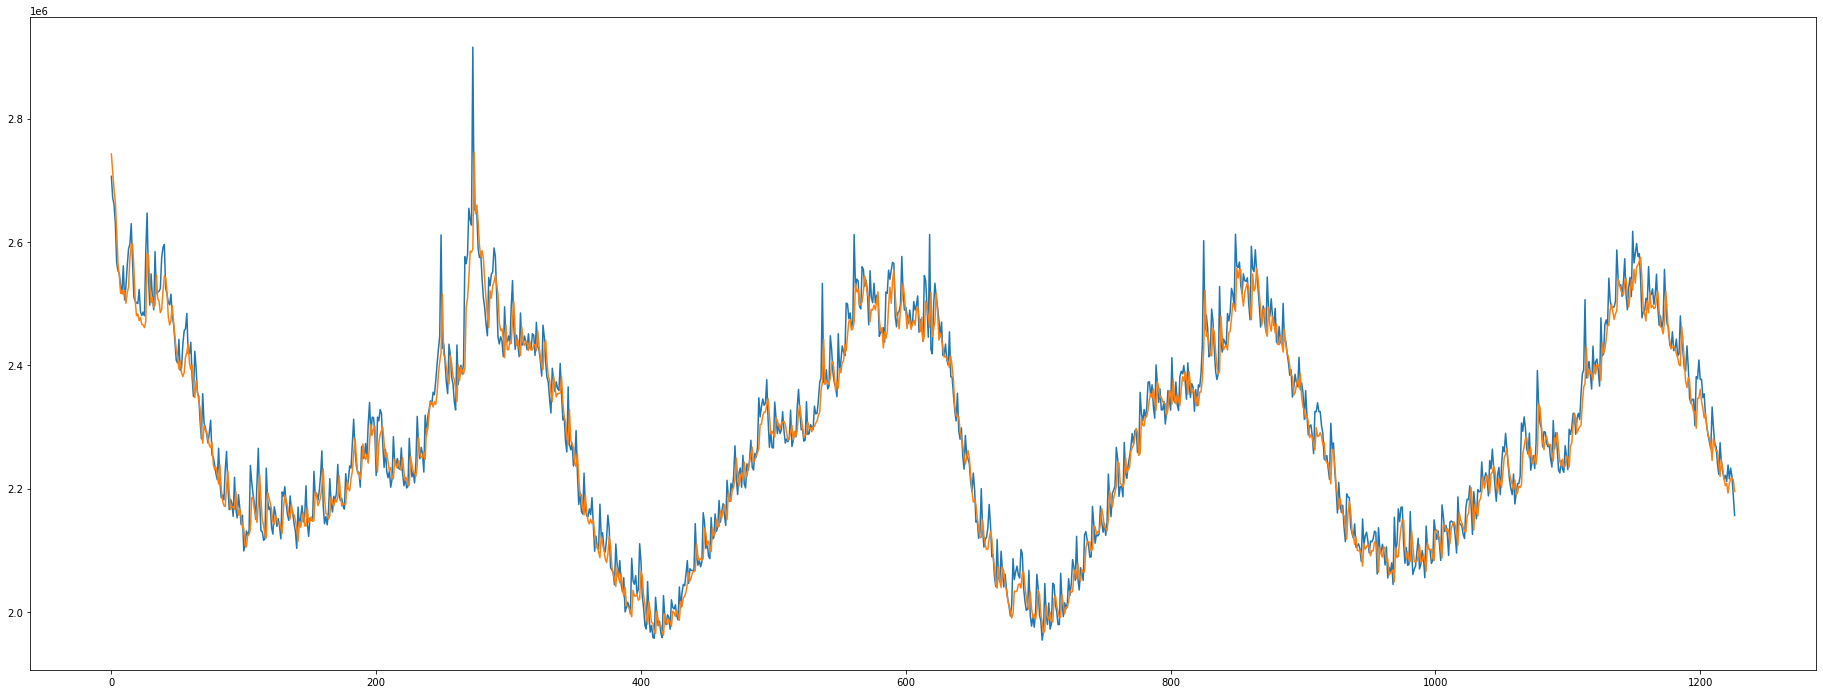

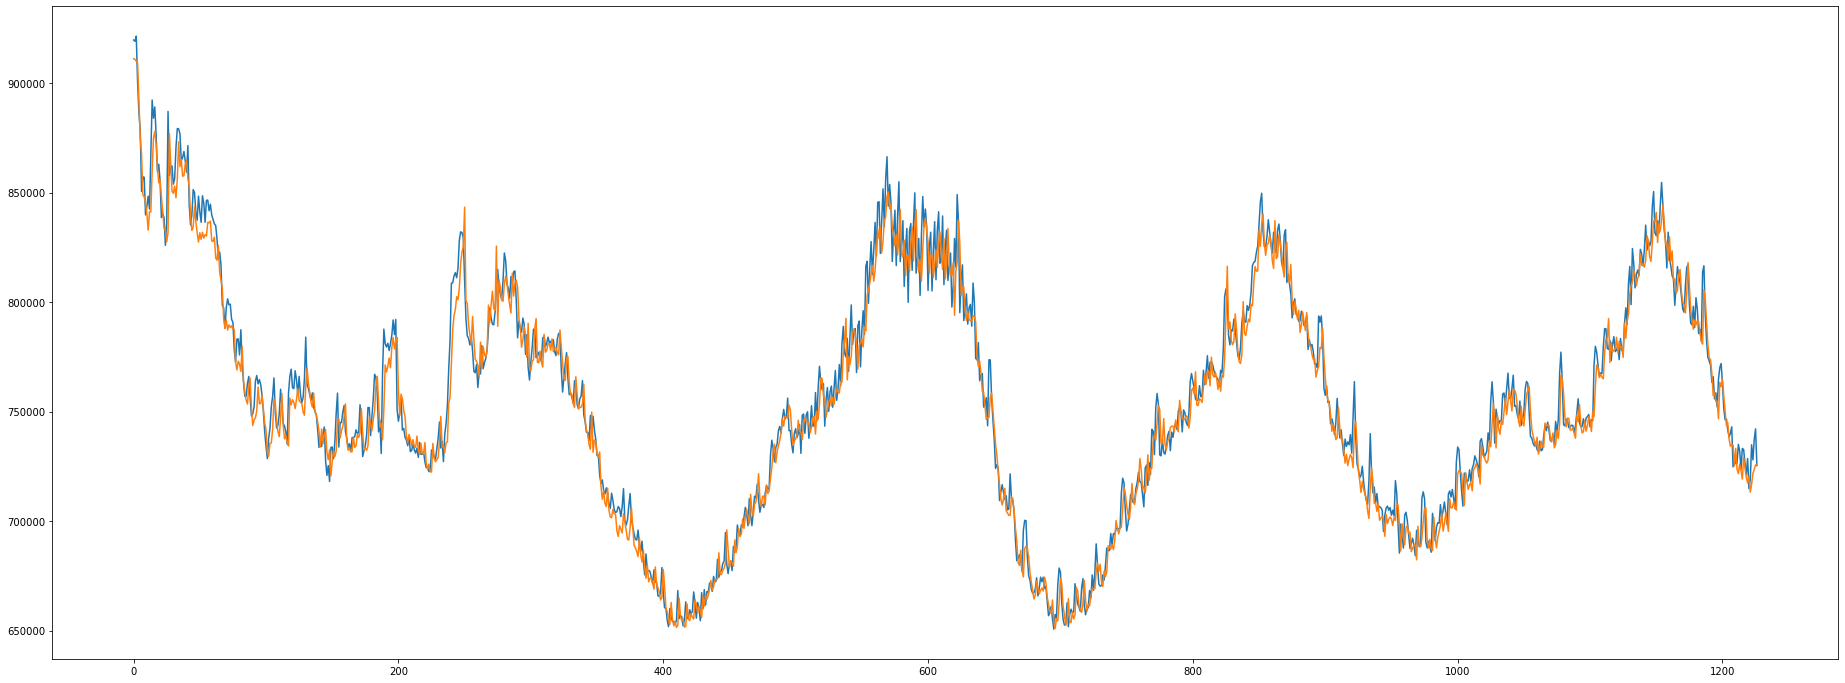

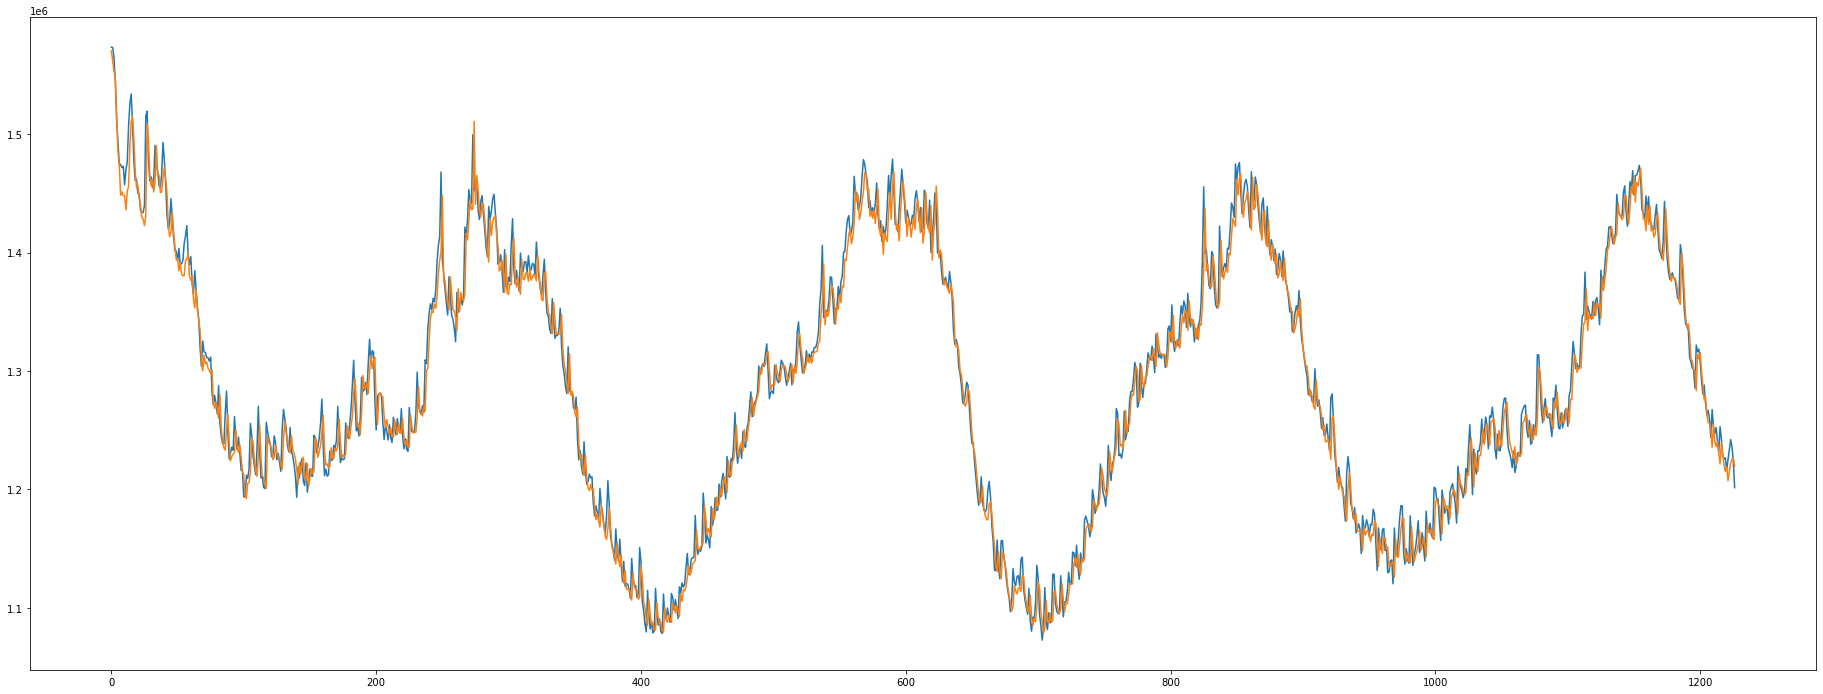

In [14]:
#-----------------------------------------------------------
# MAKING PREDICTIONS ON TEST DATA AND PLOTTING PREDICTED AND
# OBSERVED VALUES
#-----------------------------------------------------------
preds = model.predict(X_test_scaled)
preds = scaler.inverse_transform(preds)
plt.rcParams["figure.figsize"] = (32,12)
TestY= pd.DataFrame(y_test,columns=['min_cpu','max_cpu','avg_cpu'])
PredY=pd.DataFrame(preds,columns=['min_cpu','max_cpu','avg_cpu'])


plot_max = plt.figure(1)
plt.plot(TestY['max_cpu'])
plt.plot(PredY['max_cpu'])
plt.show()

plot_min = plt.figure(2)
plt.plot(TestY['min_cpu'])
plt.plot(PredY['min_cpu'])
plt.show()

plot_avg = plt.figure(3)
plt.plot(TestY['avg_cpu'])
plt.plot(PredY['avg_cpu'])
plt.show()

In [16]:
#-----------------------------------------------------------
# LETS CHECK HOW GOOD THE MODEL PERFORMED
#-----------------------------------------------------------
testScore_1 = math.sqrt(mean_squared_error(y_test[:], preds[:]))
print('Test Score: %.2f RMSE' % (testScore_1))

testScore_2 = math.sqrt(mean_absolute_error(y_test[:], preds[:]))
print('Test Score: %f MAE' % (testScore_2))

testScore_3 = np.mean(np.abs(preds - y_test)/np.abs(y_test)*100)
print('Test Score: %f MAPE' % (testScore_3))

Test Score: 23987.87 RMSE
Test Score: 123.022565 MAE
Test Score: 1.004987 MAPE
